In [1]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="my-test-unet")

wandb: Currently logged in as: fercos. Use `wandb login --relogin` to force relogin


In [2]:
import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import cv2
import numpy as np
from diametery.fiber import Fiber, Image, img_size
from tensorflow.keras.optimizers import Adam
from tensorflow.data import Dataset
import sys

tf.debugging.enable_check_numerics(
    stack_height_limit=30, path_length_limit=50
)


INFO:tensorflow:Enabled check-numerics callback in thread MainThread


In [3]:
def unet(pretrained_weights = None, input_size = img_size+[1], num_classes=2):
    initial_features = 16
    inputs = layers.Input(input_size)
    conv1 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(inputs)
    conv1 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool1)
    conv2 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool2)
    conv3 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool3)
    conv4 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv4)
    drop4 = layers.Dropout(0.5)(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = layers.Conv2D(initial_features*2**4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(pool4)
    conv5 = layers.Conv2D(initial_features*2**4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv5)
    drop5 = layers.Dropout(0.5)(conv5)

    up6 = layers.Conv2D(initial_features*2**3, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = tf.concat([drop4,up6], axis = 3)
    conv6 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge6)
    conv6 = layers.Conv2D(initial_features*2**3, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv6)

    up7 = layers.Conv2D(initial_features*2**2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = tf.concat([conv3,up7], axis = 3)
    conv7 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge7)
    conv7 = layers.Conv2D(initial_features*2**2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv7)

    up8 = layers.Conv2D(initial_features*2, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = tf.concat([conv2,up8], axis = 3)
    conv8 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge8)
    conv8 = layers.Conv2D(initial_features*2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv8)

    up9 = layers.Conv2D(initial_features, 2, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = tf.concat([conv1,up9], axis = 3)
    conv9 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(merge9)
    conv9 = layers.Conv2D(initial_features, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv9)
    conv9 = layers.Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'glorot_uniform')(conv9)
    conv10 = layers.Conv2D(num_classes, 1, activation = 'tanh', padding='same')(conv9)

    model = keras.Model(inputs, conv10)
    return model

In [4]:

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + [1,])

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 1, strides=1, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 1, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 1, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 1, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 1, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Project residual
        if filters != 32:
            x = layers.UpSampling2D(2)(x)
            residual = layers.UpSampling2D(2)(previous_block_activation)
        else:
            residual = previous_block_activation
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 1, activation="tanh", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()


In [5]:
# Build model
num_classes = 2
model = unet()
model.summary()

2022-06-12 11:18:28.043568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 11:18:28.206558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 11:18:28.207438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-12 11:18:28.209110: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
nrm = Normalize(vmin=-1, vmax=1)


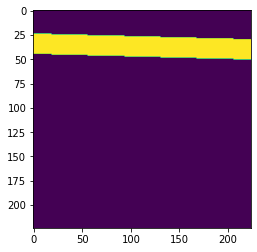

In [8]:
img = Image.create()
im = img.render_image().astype(np.float32) / 255
im = np.expand_dims(im, axis=-1)
im.shape
plt.imshow(im)

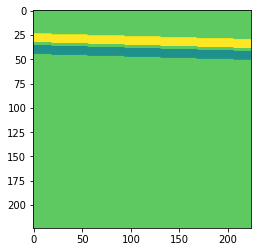

In [9]:
field_and_weights = img.render_field_and_weights()
field_and_weights.shape
im_rgb = nrm(field_and_weights)
plt.imshow(im_rgb[:,:,1], norm=nrm)

In [10]:
pred = model(np.array([im]))
# pred[0][0]

2022-06-12 11:18:35.928547: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


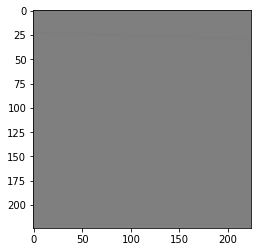

In [11]:
im_b = np.zeros(pred[0,:,:,0].shape, dtype=float)
im_rgb = np.stack([pred[0, :, :, 0],pred[0, :, :, 1], im_b], axis=-1)
im_rgb = nrm(im_rgb)
plt.imshow(im_rgb, norm=nrm)

In [12]:
img.render_field_and_weights()[:,:,0:2].shape

(224, 224, 2)

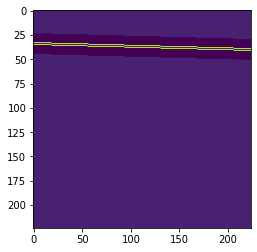

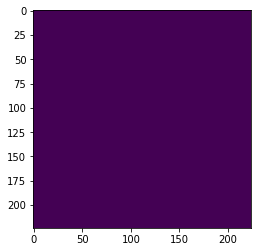

In [13]:
from diametery.skeleton import get_total_flux
plt.imshow(get_total_flux(img.render_field_and_weights()[:,:,0:2]))
plt.show()
plt.imshow(get_total_flux(pred[0]))
plt.show()

In [14]:
def weighted_l2(y_true, y_pred):
    f_true = y_true[:,:,:,0:2]
    w = y_true[:,:,:,2]
    diff = tf.subtract(f_true, y_pred, name='diff')
    tf.print(tf.reduce_mean(diff), output_stream=sys.stdout)
    l2 = tf.math.reduce_euclidean_norm(
        diff, axis=-1, keepdims=False, name='euclidean_norm')
    tf.print(tf.reduce_mean(l2), output_stream=sys.stdout)
    weighted_l2 = tf.multiply(w, l2)
    tf.print(tf.reduce_mean(weighted_l2), output_stream=sys.stdout)
    # return weighted_l2
    loss = tf.reduce_mean(weighted_l2, axis=[-2,-1])
    tf.print(loss, output_stream=sys.stdout)
    return loss

In [15]:
from keras.losses import mean_squared_error
def weighted_mse(y_true, y_pred):
    f_true = y_true[:,:,:,0:2]
    w = y_true[:,:,:,2]
    loss = mean_squared_error(f_true, y_pred)
    weighted_loss = tf.multiply(w, loss)
    return weighted_loss


In [16]:
y_true = img.render_field_and_weights()
y_true = np.array([y_true])
loss = weighted_l2(y_true, pred)
loss.shape

0.000324018154
0.0808186755
0.0728891641
[0.0728891641]


TensorShape([1])

In [17]:
y_true.shape, pred.shape

((1, 224, 224, 3), TensorShape([1, 224, 224, 2]))

In [18]:
adam = Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss=weighted_mse)

In [19]:
def epoch_gen(batch_size=8, n_batches=10):
    for _ in range(n_batches):
        X = []
        Y = []
        for _ in range(batch_size):
            img = Image.create()
            x = img.render_image().astype(np.float32) / 255
            x = np.expand_dims(x, axis=-1)
            y = img.render_field_and_weights()
            X.append(x)
            Y.append(y)
        X = np.array(X)
        Y = np.array(Y)
        yield X, Y

In [20]:
from tqdm import tqdm

for x,y in tqdm(epoch_gen()):
    pass

10it [00:00, 59.59it/s]


In [21]:
test_x, test_y = zip(*epoch_gen(32, 1))
test_x= tf.constant(test_x[0])
test_y = tf.constant(test_y[0])
test_x

<tf.Tensor: shape=(32, 224, 224, 1), dtype=float32, numpy=
array([[[[0.2       ],
         [0.2       ],
         [0.2       ],
         ...,
         [0.6       ],
         [0.6       ],
         [0.6       ]],

        [[0.2       ],
         [0.2       ],
         [0.2       ],
         ...,
         [0.6       ],
         [0.6       ],
         [0.6       ]],

        [[0.2       ],
         [0.2       ],
         [0.2       ],
         ...,
         [0.6       ],
         [0.6       ],
         [0.6       ]],

        ...,

        [[0.2       ],
         [0.2       ],
         [0.2       ],
         ...,
         [0.2       ],
         [0.2       ],
         [0.2       ]],

        [[0.2       ],
         [0.2       ],
         [0.2       ],
         ...,
         [0.2       ],
         [0.2       ],
         [0.2       ]],

        [[0.2       ],
         [0.2       ],
         [0.2       ],
         ...,
         [0.2       ],
         [0.2       ],
         [0.2       ]]],


 

In [22]:
ds = Dataset.from_generator(
    epoch_gen,
    output_types=(tf.float32, tf.float32),
)

In [23]:
# for i in test_set_ds.as_numpy_iterator():
#     print(i[1].shape)

In [24]:
model.fit(ds.prefetch(1), validation_data=(test_x, test_y), epochs=1000, callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/1000
     10/Unknown - 10s 221ms/step - loss: 0.0575

2022-06-12 11:19:06.130560: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 800.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-12 11:19:06.130664: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 800.00MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-12 11:19:06.130753: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 790.01MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-12 11:19:06.130798: W tensorflow/core/common_runtime/bfc_allocator.cc:275]

10/10 [==============================] - 15s 714ms/step - loss: 0.0575 - val_loss: 0.0604 - _timestamp: 1655025546.0000 - _runtime: 43.0000
Epoch 2/1000
10/10 [==============================] - ETA: 0s - loss: 0.0578

2022-06-12 11:19:09.538136: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 166.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-12 11:19:09.538521: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 110.81MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-06-12 11:19:09.697347: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 248.07MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


10/10 [==============================] - 3s 300ms/step - loss: 0.0578 - val_loss: 0.0603 - _timestamp: 1655025549.0000 - _runtime: 46.0000
Epoch 3/1000
10/10 [==============================] - ETA: 0s - loss: 0.0553

2022-06-12 11:19:12.338002: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 166.50MiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


10/10 [==============================] - 3s 276ms/step - loss: 0.0553 - val_loss: 0.0600 - _timestamp: 1655025552.0000 - _runtime: 49.0000
Epoch 4/1000
10/10 [==============================] - 3s 273ms/step - loss: 0.0605 - val_loss: 0.0594 - _timestamp: 1655025555.0000 - _runtime: 52.0000
Epoch 5/1000
10/10 [==============================] - 3s 277ms/step - loss: 0.0585 - val_loss: 0.0576 - _timestamp: 1655025558.0000 - _runtime: 55.0000
Epoch 6/1000
10/10 [==============================] - 3s 277ms/step - loss: 0.0566 - val_loss: 0.0555 - _timestamp: 1655025560.0000 - _runtime: 57.0000
Epoch 7/1000
10/10 [==============================] - 3s 253ms/step - loss: 0.0590 - val_loss: 0.0559 - _timestamp: 1655025563.0000 - _runtime: 60.0000
Epoch 8/1000
10/10 [==============================] - 3s 279ms/step - loss: 0.0486 - val_loss: 0.0533 - _timestamp: 1655025566.0000 - _runtime: 63.0000
Epoch 9/1000
10/10 [==============================] - 3s 280ms/step - loss: 0.0540 - val_loss: 0.0522

In [26]:
model.save("20220612-1000epochs.hdf5")

In [56]:
def predict_diameter(flux):
    return np.median(flux[flux>1])

In [57]:
import pandas as pd
import seaborn as sns

def get_diam_and_pred():
    img = Image.create()
    im = img.render_image().astype(np.float32) / 255
    calc_flux = get_total_flux(img.render_field_and_weights()[:,:,0:2])
    calc_d = predict_diameter(calc_flux)

    # generate prediction
    pred = model(np.array([im]))
    pred_flux = get_total_flux(pred[0])
    pred_d = predict_diameter(pred_flux)
    # images from prediction
    nrm = Normalize(vmin=-1, vmax=1)
    pred_rgb = np.stack([pred[0, :, :, 0],pred[0, :, :, 1], np.zeros(pred[0,:,:,0].shape, dtype=float)], axis=-1)
    pred_rgb = nrm(pred_rgb)

    ans = {
            "known_d":img.fiber.diameter,
            'calc_d':calc_d,
            "pred_d":pred_d,
            'img':img,
            'pred':pred,
            "pred_rgb":pred_rgb,
            "calc_flux":calc_flux,
            "pred_flux":pred_flux
        }
    return ans

# get_diam_and_pred()

In [58]:
dicts = []
for i in range(50):
    dicts.append(get_diam_and_pred())
df = pd.DataFrame(dicts)


In [70]:
df['calc_error'] = df.known_d - df.calc_d*2
df['pred_error'] = df.known_d - df.pred_d*2
df = df.sort_values('calc_error', ascending=True, ignore_index=True)

<AxesSubplot:xlabel='known_d', ylabel='calc_error'>

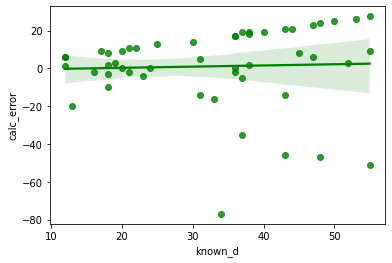

In [60]:
sns.regplot(x='known_d', y='calc_error', color="g", data=df)

<AxesSubplot:xlabel='known_d', ylabel='pred_error'>

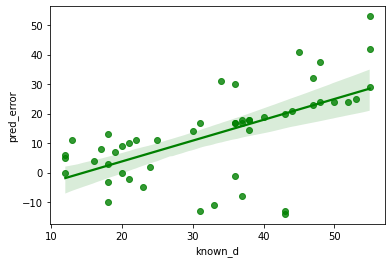

In [61]:
sns.regplot(x='known_d', y='pred_error', color="g", data=df)

In [32]:
def get_flow(field):
    return np.gradient(field, axis=[0,1])

get_flow(df.iloc[0].pred)

ValueError: Shape of array too small to calculate a numerical gradient, at least (edge_order + 1) elements are required.

In [77]:
def get_total_flux(flux, threshold=1/5):
    """Flux has dimensions (height, width, flux)"""
    # N is the binned direction matrix 
    N = np.zeros(flux.shape, dtype=np.int32)
    N[flux > threshold] = 1
    N[flux < -threshold] = -1
    h, w, _ = N.shape
    total_flux = np.zeros(shape=(h,w))
    for x_position in range(w):
        for y in range(h):
            x = x_position
            visited = [(x,y)]
            dx, dy = N[y,x]
            out_of_bounds = False
            while not(dx == 0 and dy == 0):
                x += dx
                y += dy
                if not 0 <= x < w:
                    out_of_bounds = True
                    break
                if not 0 <= y < h:
                    out_of_bounds = True
                    break
                if (x,y) in visited:
                    #cycle_detected = True
                    break
                dx, dy = N[y,x]
                visited.append((x,y))
            if not out_of_bounds:
                total_flux[y,x] += 1
    return total_flux


In [81]:
np.meshgrid(np.linspace(-5,5,10),np.linspace(-5,5,10)).shape

AttributeError: 'list' object has no attribute 'shape'

In [133]:
field = np.array([
    [[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]],
    [[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]],
    [[0.5, 0.5], [0.5, 0.5], [0.5, 0.5]],
])

def plot_field(field):
    x,y = np.meshgrid(range(field.shape[0]), range(field.shape[1]))
    x,y
    u = field[:,:,0]
    v = -field[:,:,1] 
    plt.quiver(x,y,u,v, angles='uv', pivot='mid', width=0.001, headwidth=1.5, headlength=1, headaxislength=1, minlength=0.5)
    plt.streamplot(x,y,u,v, minlength=0.05)


Error in callback <function _WandbInit._resume_backend at 0x7fd77bbf9430> (for pre_run_cell):


Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._pause_backend at 0x7fd6fa405550> (for post_run_cell):


Exception: The wandb backend process has shutdown

Error in callback <function _WandbInit._resume_backend at 0x7fd77bbf9430> (for pre_run_cell):


Exception: The wandb backend process has shutdown

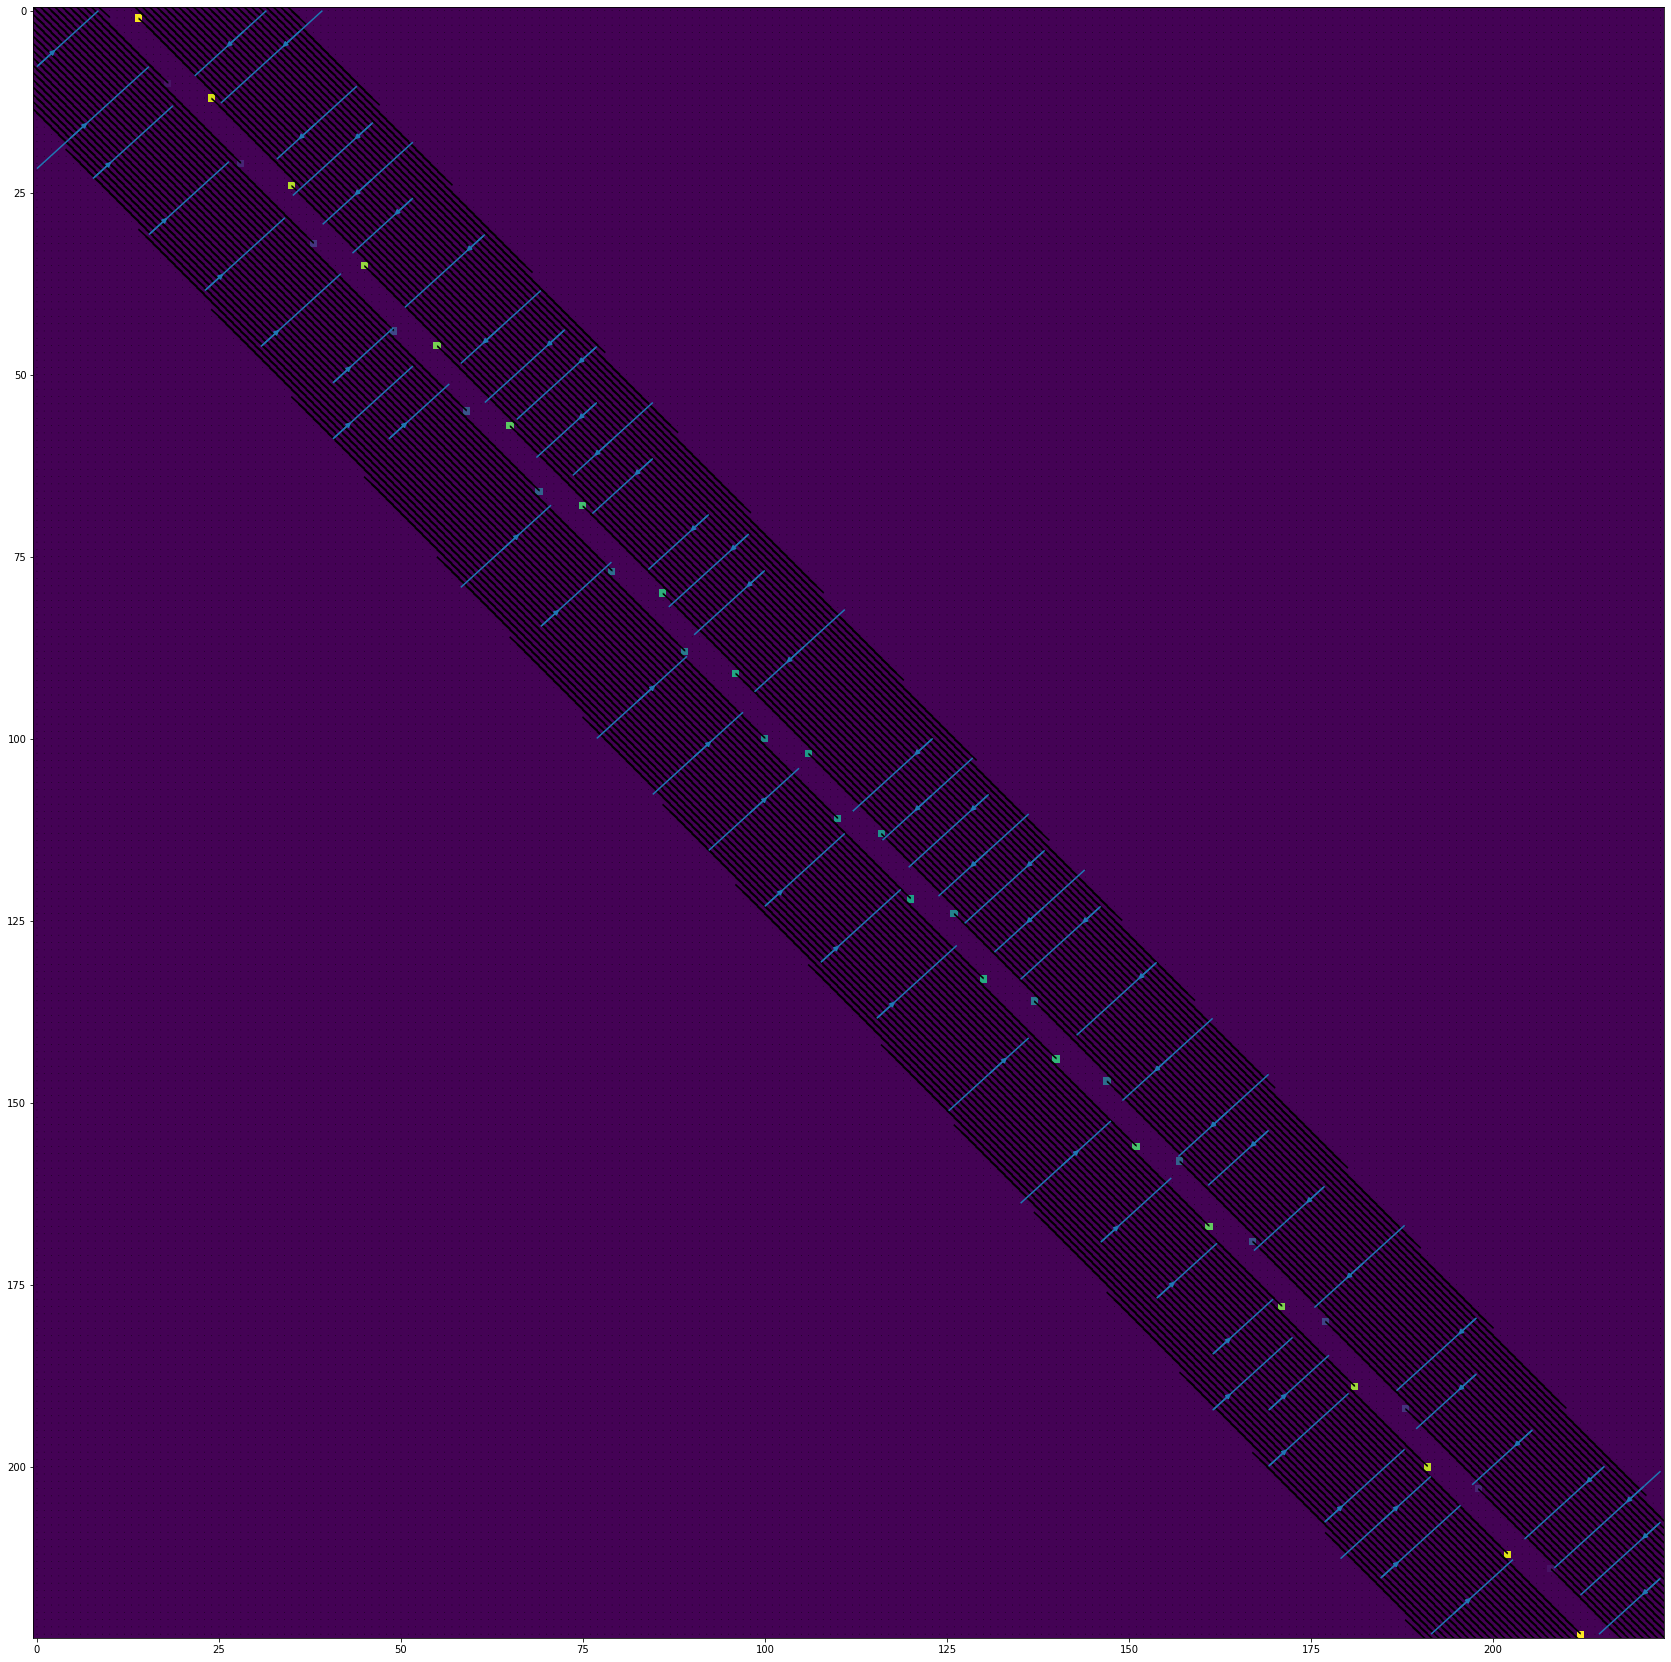

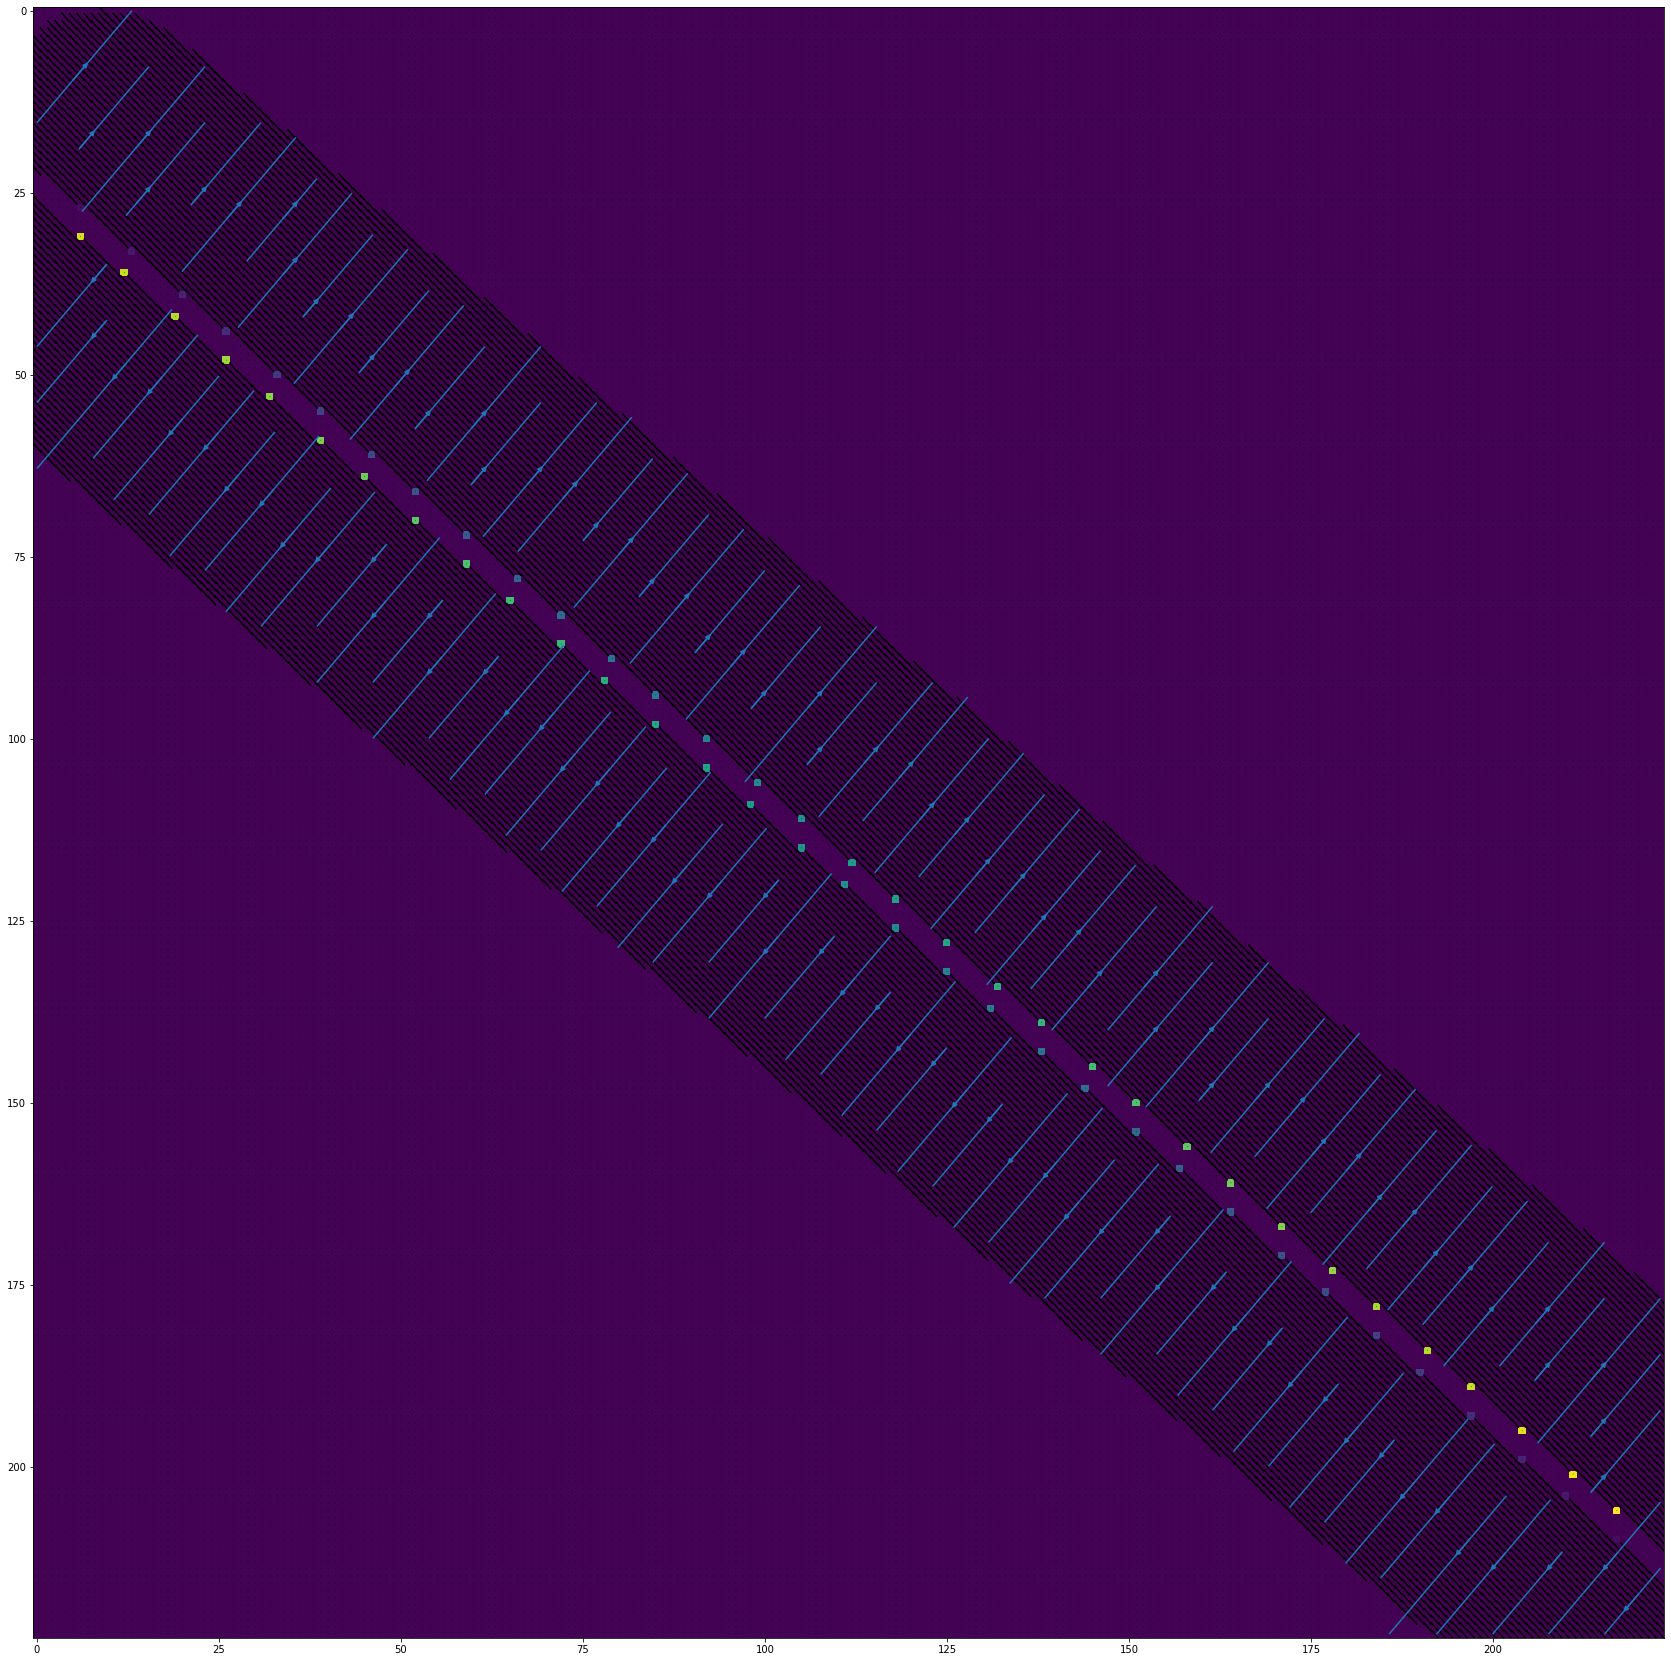

Error in callback <function _WandbInit._pause_backend at 0x7fd6fa405550> (for post_run_cell):


Exception: The wandb backend process has shutdown

In [134]:
from itertools import islice
for i, row in islice(df.iterrows(), 2):
    plt.figure(1, figsize=(30,30))
    # plt.subplot(411)
    # plt.title(f"{i}: d={row.known_d}, calc_d={row.calc_d*2}, pred_d={row.pred_d*2}")
    # plt.imshow(row.img.render_image())
    # plt.subplot(412)
    calc_field = row.img.render_field_and_weights()[:,:,0:2]
    calc_flux = get_total_flux(calc_field)
    plt.imshow(calc_flux)
    plot_field(calc_field)
    # plt.subplot(413)
    # pred_flux = row.pred_flux > 2
    # plt.imshow(pred_flux)
    # plot_field(row.pred[0])
    plt.show()

<AxesSubplot:xlabel='known_d', ylabel='pred_d'>

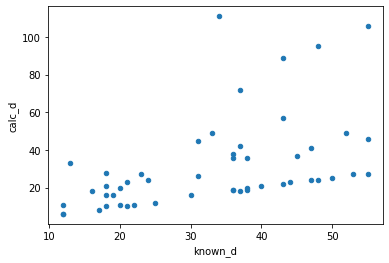

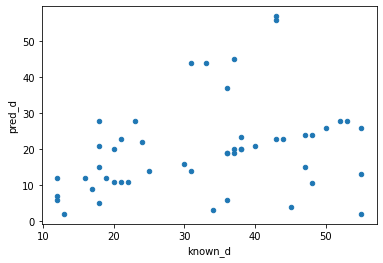

In [ ]:
df.plot(x='known_d', y='calc_d', kind='scatter')
df.plot(x='known_d', y='pred_d', kind='scatter')



In [133]:
flux[flux>1].mean()

10.617886178861788